# Time Series Forecasting using XGBoost



In [0]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import io
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from scipy.spatial.distance import cdist
import io
import pandas as pd

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, Dropout, LSTM
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

# Data
Using the CIL data

In [0]:
from google.colab import files
uploaded = files.upload()

Saving TrainActualConsumptionData.csv to TrainActualConsumptionData.csv
Saving SampleSubmission3.csv to SampleSubmission3.csv
Saving TestActualConsumptionData.csv to TestActualConsumptionData.csv
Saving TestProdData.csv to TestProdData.csv
Saving TrainPlannedDailyProduction.csv to TrainPlannedDailyProduction.csv
Saving TrainProdData.csv to TrainProdData.csv


In [0]:


df_TestActualConsumptionData = pd.read_csv('TestActualConsumptionData.csv')
df_TestProdData = pd.read_csv('TestProdData.csv')
df_TrainActualConsumptionData = pd.read_csv('TrainActualConsumptionData.csv')
df_TrainPlannedDailyProduction = pd.read_csv('TrainPlannedDailyProduction.csv')
df_TrainProdData = pd.read_csv('TrainProdData.csv')

df_SampleSubmission3 = pd.read_csv('SampleSubmission3.csv')



#ActualConsumptionData_all = pd.concat([df_TrainActualConsumptionData, df_TestActualConsumptionData], sort=False)
#TrainProdData_all = pd.concat([df_TrainProdData, df_TestProdData], sort=False)

ActualConsumptionData_all = df_TrainActualConsumptionData
TrainProdData_all = df_TrainProdData

In [0]:
df_TrainActualConsumptionData

In [0]:
df_TrainProdData.head()

In [0]:
df_TrainProdData.head();

In [0]:
df_TrainActualConsumptionData['DateTime'] = pd.to_datetime(ActualConsumptionData_all['ConsumptionDate'],format='%d/%m/%Y %H:%M')
df_TrainProdData['DateTime'] = pd.to_datetime(TrainProdData_all['ProductionDate'],format='%d/%m/%Y %H:%M')
merged_df = df_TrainActualConsumptionData.merge(df_TrainProdData, left_on='DateTime', right_on='DateTime')

merged_df['hour'] = merged_df['DateTime'].dt.hour
merged_df['dayofweek'] = merged_df['DateTime'].dt.dayofweek
merged_df['month'] = merged_df['DateTime'].dt.month
merged_df['year'] = merged_df['DateTime'].dt.year
# merged_df['dayofyear'] = merged_df['DateTime'].dt.dayofyear
merged_df['dayofmonth'] = merged_df['DateTime'].dt.day
merged_df['weekofyear'] = merged_df['DateTime'].dt.weekofyear

merged_df.set_index('DateTime', inplace=True)

df_TestActualConsumptionData['DateTime'] = pd.to_datetime(df_TestActualConsumptionData['ConsumptionDate'], format='%d/%m/%Y %H:%M')
df_TestProdData['DateTime'] = pd.to_datetime(df_TestProdData['ProductionDate'], format='%d/%m/%Y %H:%M')

merged_test = df_TestActualConsumptionData.merge(df_TestProdData, left_on='DateTime', right_on='DateTime')
merged_test['hour'] = merged_test['DateTime'].dt.hour
merged_test['dayofweek'] = merged_test['DateTime'].dt.dayofweek
merged_test['month'] = merged_test['DateTime'].dt.month
merged_test['year'] = merged_test['DateTime'].dt.year
# merged_test['dayofyear'] = merged_test['DateTime'].dt.dayofyear
merged_test['dayofmonth'] = merged_test['DateTime'].dt.day
merged_test['weekofyear'] = merged_test['DateTime'].dt.weekofyear


merged_test.set_index('DateTime', inplace=True)



def outliers(x): 
    x[np.abs(x- x.rolling(250,center=True).median()) > 1*(x.quantile(.75)-x.quantile(0.25))]=np.NaN
    return x

x = merged_df.apply(lambda s: pd.to_numeric(s, errors='coerce'))
x = x.apply(lambda s: outliers(s))
x = x[x.index < pd.to_datetime('31.3.2019')]

ser = x.fillna(method='backfill').fillna(method='bfill').fillna(method='ffill').drop(["ConsumptionDate", "ProductionDate"], axis=1)
# df_merged['DateTime'] = df_merged.index
# df_merged = df_merged.drop(columns = ['ProductionDate', 'ConsumptionDate'])
# df_merged.head()

x1 = merged_test.apply(lambda s: pd.to_numeric(s, errors='coerce'))
ser1 = x1.fillna(method='backfill').fillna(method='bfill').fillna(method='ffill').drop(["ConsumptionDate", "ProductionDate"], axis=1)

# ser1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


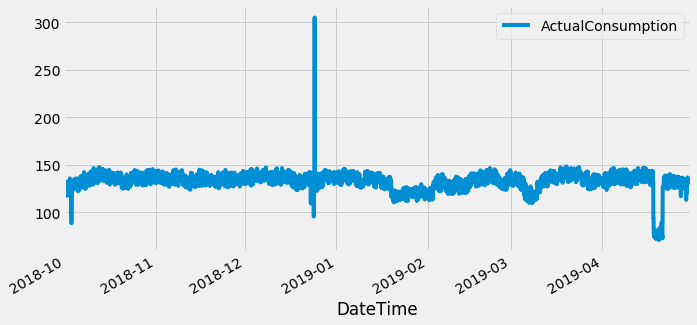

In [0]:
df_merged.plot( y=['ActualConsumption'], figsize=(10,5), grid=True)


In [0]:
# def create_features(df, label=None):
#     """
#     Creates time series features from datetime index
#     """
#     #df['date'] = df.index
#     df['hour'] = df['DateTime'].dt.hour
#     df['dayofweek'] = df['DateTime'].dt.dayofweek
#     df['month'] = df['DateTime'].dt.month
#     df['year'] = df['DateTime'].dt.year
#     df['dayofmonth'] = df['DateTime'].dt.day
#     df['weekofyear'] = df['DateTime'].dt.weekofyear
    
#     dateTime_features = df[['hour','dayofweek','month','year','dayofmonth','weekofyear']]
#     if label:
#         y = df[label]
#         return df, y
#     return df

# X_train_set, y_train_set = create_features(df_merged, label='ActualConsumption')
# # X_train_set = X_train_set.drop(columns=['DateTime', 'ActualConsumption'])
# # X_train_set.head()



,P7Cons,P2Cons,P1Cons,P9Cons,P3Cons,P4Cons,P5Cons,P6Cons1,P6Sec3Cons2,P6Sec2Cons3,Gen1num1,Gen1num2,Gen2,temp,humidity,barometric,P1prod,P1num1,P1num2,P1num3,P1num4,P1num5,P2num1,P2prod,P3num1,P3num2,P3num3,P3prod,P4prod,P5prod,P6prod,P6Sec1num1,P6Sec2num2,P6Sec3num3,P6Sec4num4,P7num1,P7num2,P7num3,P7num4,hour,dayofweek,month,year,dayofmonth,weekofyear
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-01 00:00:00,57.210,2.710,13.632,1.774,12.224,7.652,6.006,10.334,0.838,0.0,154.440,47.594,16.322,35.384502,40.378746,1053.343882,4.530814,12.002213,12.003821,454.190665,457.317411,0.555714,27.970287,20.253054,41.826847,88.676324,22.792987,235.897234,153.436667,129.331998,2082.549038,68562.86296,21147.36788,28454.376770,71945.46871,1225.035020,1280.006601,0.0,32.2,0,0,10,2018,1,40
2018-10-01 00:30:00,58.038,2.712,13.666,1.734,12.202,7.668,6.110,11.820,0.734,0.0,154.630,47.974,16.316,34.864383,41.560707,1053.742448,4.522578,12.002876,12.003983,454.187500,457.393270,0.746059,26.791037,20.010364,41.381980,84.266948,22.025751,245.894979,105.323682,126.833709,2383.595363,68673.18029,34525.18855,25359.742260,71964.70985,1225.007220,1270.199192,0.0,32.2,0,0,10,2018,1,40
2018-10-01 01:00:00,60.694,2.712,13.630,1.668,12.174,7.856,6.120,10.964,0.000,0.0,154.706,47.938,15.458,34.707082,41.167028,1053.135506,4.527633,12.003097,12.002872,454.215915,457.408942,0.500045,24.507935,20.125844,41.452514,81.932914,22.110157,237.825323,117.346840,129.426343,2301.260985,68618.74011,34328.58152,109.291866,72043.25935,1223.974071,1274.886934,0.0,32.2,1,0,10,2018,1,40
2018-10-01 01:30:00,60.760,2.706,13.642,1.720,12.214,8.562,6.184,10.920,0.268,0.0,155.002,48.084,16.292,34.593154,41.230346,1053.097943,4.526980,12.000941,12.002335,454.184335,457.358599,0.184486,24.274768,20.237655,40.907064,84.238147,22.552562,238.376984,221.158765,130.571592,2155.206902,68686.21016,24770.93921,9683.655046,72007.80584,1236.716836,1291.933899,0.0,32.2,1,0,10,2018,1,40
2018-10-01 02:00:00,62.190,2.702,13.600,1.758,12.240,8.554,6.192,11.854,0.778,0.0,155.466,47.906,16.236,34.287583,41.394113,1053.133659,4.534506,12.003045,12.002289,454.200139,457.377925,0.216415,24.774497,20.163674,40.653111,84.544132,22.609419,230.868582,234.594473,127.397142,1988.036858,68640.45397,17908.31626,29797.907260,72111.08737,1246.097254,1277.930295,0.0,32.2,2,0,10,2018,1,40


# Train/Test Split
Cut off the data after 2015 to use as our validation set.

In [0]:
# #split_date = '31/03/2019 0:00:00'
# split_date = '17/03/2019 0:00:00'

# #X_train_set = pd.DataFrame(X_train_set)
# X_train = X_train_set.loc[X_train_set.index <= split_date].copy()
# X_test = X_train_set.loc[X_train_set.index > split_date].copy()

# y_train = y_train_set.loc[y_train_set.index <= split_date].copy()
# y_test = y_train_set.loc[y_train_set.index > split_date].copy()


X_train = ser
Y_train = X_train['ActualConsumption']
X_train = X_train.drop(["ActualConsumption"], axis=1);
X_train = X_train.as_matrix()

X_test = ser1
Y_test = X_test['ActualConsumption']
X_test = X_test.drop(["ActualConsumption"], axis=1);
X_test = X_test.as_matrix()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [0]:
print(X_train.head())
# print(y_test.head())


                     P7Cons  P2Cons  P1Cons  ...  year  dayofmonth  weekofyear
DateTime                                     ...                              
2018-10-01 00:00:00  57.210   2.710  13.632  ...  2018           1          40
2018-10-01 00:30:00  58.038   2.712  13.666  ...  2018           1          40
2018-10-01 01:00:00  60.694   2.712  13.630  ...  2018           1          40
2018-10-01 01:30:00  60.760   2.706  13.642  ...  2018           1          40
2018-10-01 02:00:00  62.190   2.702  13.600  ...  2018           1          40

[5 rows x 45 columns]


In [0]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Create Time Series Features

# Create XGBoost Model

In [0]:
model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [0]:
history = model.fit(X_train, Y_train, epochs=160, batch_size=70, validation_data=(X_test, Y_test), verbose=2, shuffle=False)

Train on 8686 samples, validate on 1440 samples
Epoch 1/160
 - 1s - loss: 150.4058 - val_loss: 2473.1923
Epoch 2/160
 - 1s - loss: 148.3333 - val_loss: 2473.5226
Epoch 3/160
 - 1s - loss: 151.0042 - val_loss: 2470.7656
Epoch 4/160
 - 1s - loss: 154.0455 - val_loss: 2477.5685
Epoch 5/160
 - 1s - loss: 150.1404 - val_loss: 2481.3192
Epoch 6/160
 - 1s - loss: 151.3558 - val_loss: 2479.4628
Epoch 7/160
 - 1s - loss: 149.7257 - val_loss: 2477.4287
Epoch 8/160
 - 1s - loss: 144.7221 - val_loss: 2477.8277
Epoch 9/160
 - 1s - loss: 148.3625 - val_loss: 2468.7497
Epoch 10/160
 - 1s - loss: 149.5072 - val_loss: 2470.4987
Epoch 11/160
 - 1s - loss: 149.8413 - val_loss: 2471.0947
Epoch 12/160
 - 1s - loss: 146.7482 - val_loss: 2476.2606
Epoch 13/160
 - 1s - loss: 148.6489 - val_loss: 2473.7086
Epoch 14/160
 - 1s - loss: 148.9128 - val_loss: 2479.9188
Epoch 15/160
 - 1s - loss: 146.8487 - val_loss: 2476.2036
Epoch 16/160
 - 1s - loss: 149.6489 - val_loss: 2474.6969
Epoch 17/160
 - 1s - loss: 148.04

In [0]:
result = model.evaluate(X_test, Y_test)

print("Accuracy: {0:.2%}".format(result[0]))

1440/1440 [==============================] - 0s 46us/sample - loss: 2658.1082
Accuracy: 265810.82%


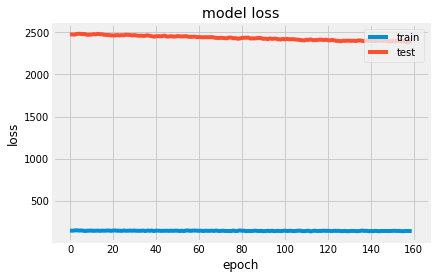

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the day of year was most commonly used to split trees, while hour and year came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

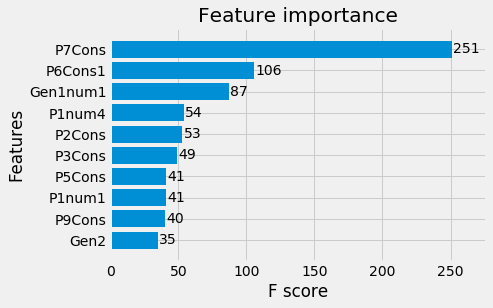

In [0]:
_ = plot_importance(reg, height=0.8, max_num_features=10)

# Forecast on Test Set

In [0]:
pred = reg.predict(X_test)
df_test_pred = pd.DataFrame({'Actual' : y_test , 'Predict': pred })

ValueError: ignored

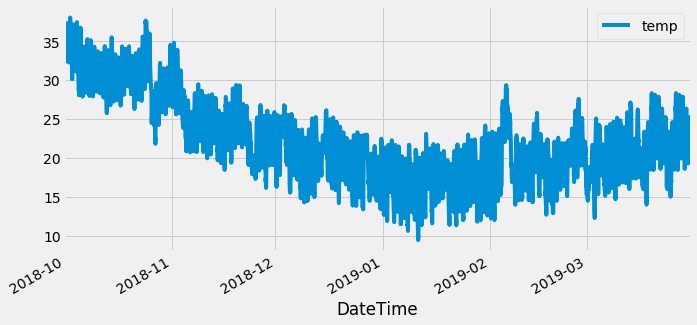

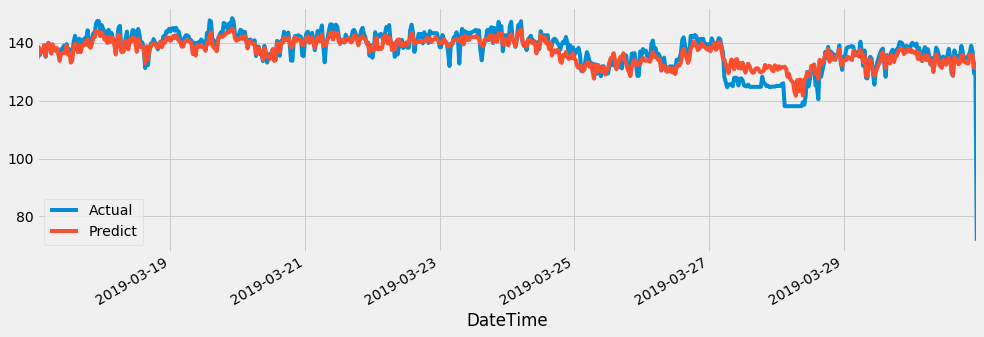

In [0]:

df_merged.plot( y=['temp'], figsize=(10,5), grid=True)

_ = df_test_pred.plot(figsize=(15, 5))

# Look at first month of predictions

NameError: ignored

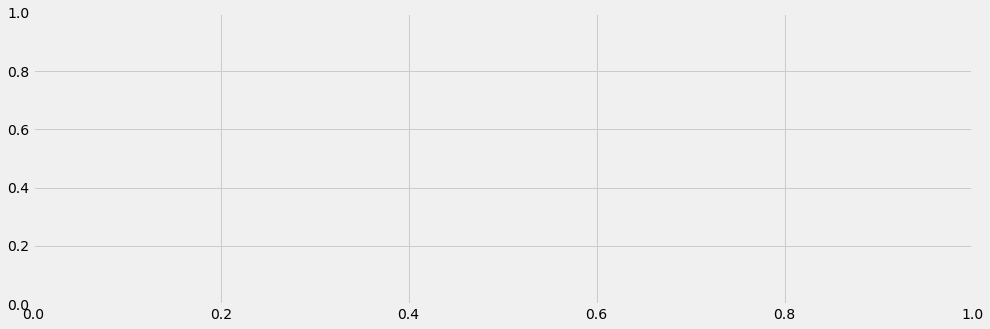

In [0]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = a_all[['Cons_Prediction','ActualConsumption']].plot(ax=ax,
                                              style=['-','.'])
plot = plt.suptitle('Forecast vs Actuals')

In [0]:
submission = pd.DataFrame({'ConsumptionDate': df_SampleSubmission3['ConsumptionDate'], 'ActualConsumption': pred})

submission.head()
# x = y_test.merge(pred)
# df['ConsumptionDate'] = merged_test['ConsumptionDate']
submission = submission.reset_index()
# a = df[['ConsumptionDate','PredictedConsumption']];
submission = submission.set_index(['ConsumptionDate'])
# a = a.rename(columns = {"PredictedConsumption": "ActualConsumption"})
submission = submission.drop(columns = ['index'])
submission.to_csv('Submission.csv')

In [0]:
df_test_pred

,Actual,Predict
DateTime,,
2019-03-17 00:30:00,134.604,134.531265
2019-03-17 01:00:00,137.624,138.054932
2019-03-17 01:30:00,135.742,135.881699
2019-03-17 02:00:00,136.846,137.152802
2019-03-17 02:30:00,136.936,137.018021
2019-03-17 03:00:00,139.114,139.401443
2019-03-17 03:30:00,135.132,135.769592
2019-03-17 04:00:00,138.322,138.639496
2019-03-17 04:30:00,139.962,140.653992


In [0]:
mean_squared_error(y_true=y_test,
                   y_pred=pred)

14.08702558856047

In [0]:
mean_absolute_error(y_true=y_test,
                   y_pred=pred)

2.23392458016206

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return (np.sum(np.abs((y_true - y_pred)) / np.sum(y_pred))) 

In [0]:
mean_absolute_percentage_error(y_true=y_test,
                   y_pred=pred)

0.016311241062576767

# Look at Worst and Best Predicted Days

In [0]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [0]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

In [0]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

In [0]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

In [0]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

In [0]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

In [0]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')